# Ajustes iniciales

## Conexión a drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


## Importar los módulos *_utils

In [5]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

In [6]:
import pickle

# Prototipo de modelo

The requirements to use the cuDNN implementation are:

1. activation == tanh
2. recurrent_activation == sigmoid
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. Inputs, if use masking, are strictly right-padded.
7. Eager execution is enabled in the outermost context.

Check: KERAS docs [https://keras.io/api/layers/recurrent_layers/lstm/]



### biLSTM

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

def bidirectionalLSTM_NetModel(task, params, optimizer, verbose = False):
  """
  Defines and compiles a new Keras model for a Convolutional Neural Network

  """

  SEQ_LENGTH = 55
  VEC_EMBEDDINGS_DIM = 300

  units_lstm = params['units_lstm']
  merge_mode = params['merge_mode']
  units_DL1, units_DL2 = params['dense_layers_sizes']

  lstm_dropout  = params['lstm_dropout']
  dense_dropout = params['dense_dropout']


  embedding_sequences_input = keras.Input(name='INPUT',
                                          shape=(SEQ_LENGTH, VEC_EMBEDDINGS_DIM), 
                                          dtype="float64")
  
  LSTM_layer    = layers.LSTM(units=units_lstm, dropout=lstm_dropout, recurrent_dropout=0, return_sequences=False, name='LSTM')
  BiLSTM_layer  = layers.Bidirectional(LSTM_layer, merge_mode, name='BI-LSTM')

  lstm_output = BiLSTM_layer(embedding_sequences_input)
  
  fc_layer_1 = layers.Dense(units_DL1, activation="relu", name = 'DL_1')(lstm_output)
  fc_layer_1 = layers.Dropout(dense_dropout, name = 'DROP_1')(fc_layer_1)
  fc_layer_2 = layers.Dense(units_DL2, activation="relu", name = 'DL_2')(fc_layer_1)
  fc_layer_2 = layers.Dropout(dense_dropout/2, name = 'DROP_2')(fc_layer_2)

  if task in ['HS', 'TR', 'AG']:
    preds = layers.Dense(1, activation="sigmoid", name = 'PREDICTOR')(fc_layer_2)
    model = keras.Model(embedding_sequences_input, preds)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

  elif task == 'HTA':
    preds = layers.Dense(5, activation="softmax", name = 'PREDICTOR')(fc_layer_2)
    preds = reshape = layers.Reshape(target_shape=(5,))(preds)

    model = keras.Model(embedding_sequences_input, preds)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

  if verbose:
    model.summary()

  return model

# Dataset

In [8]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


# Bloque 1 (optimizadores)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(450,100),
                      (400,75)]  

arch_params = {'units_lstm':[100,200,300],
          'dense_layers_sizes': dense_layers_sizes,
          'merge_mode':['concat'],
          'lstm_dropout':[0.5],                      
          'dense_dropout':[0.5]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

6 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4'],
                       'batch_size':[256,512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


18 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


108 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          bidirectionalLSTM_NetModel, 
                          search_space[40:60],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/LSTM/HTA_experiments_0_batch_3.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
with open('./Results/LSTM/BiLSTM/HTA_experiments_1.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head(10)

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

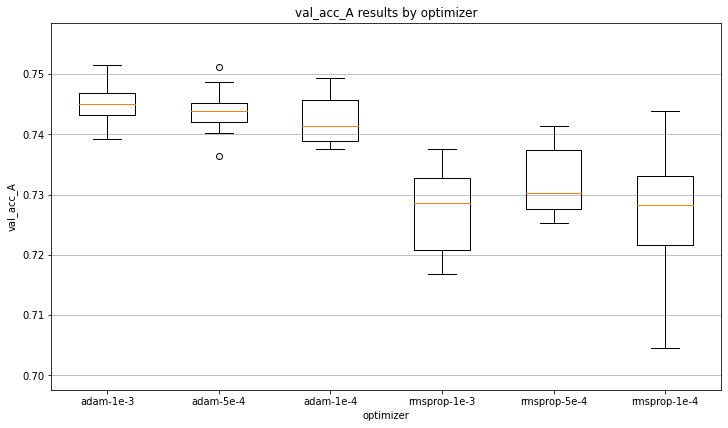

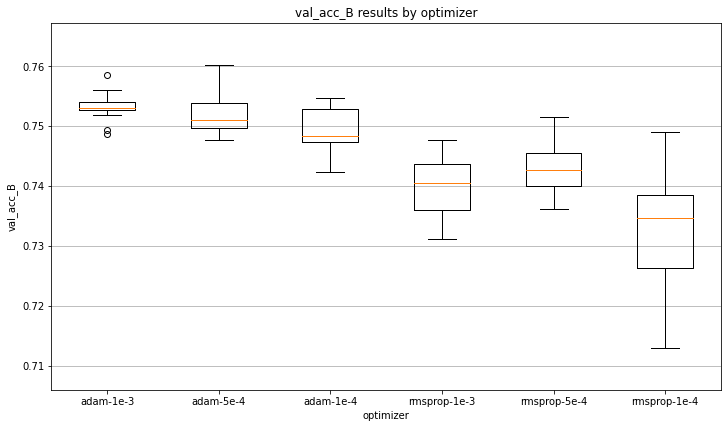

In [ ]:
params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 
                            'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4']                                
}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

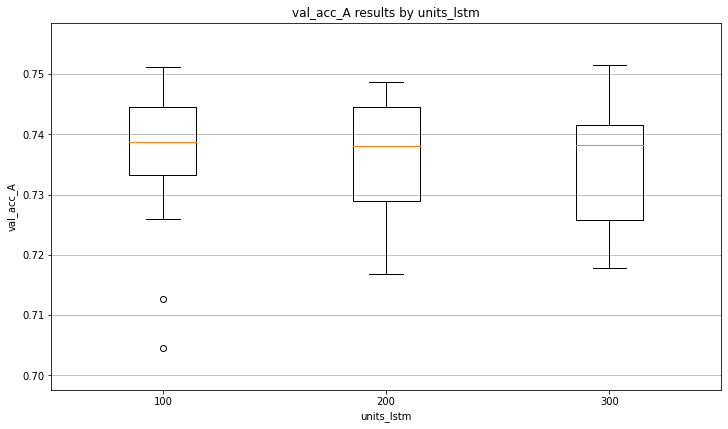

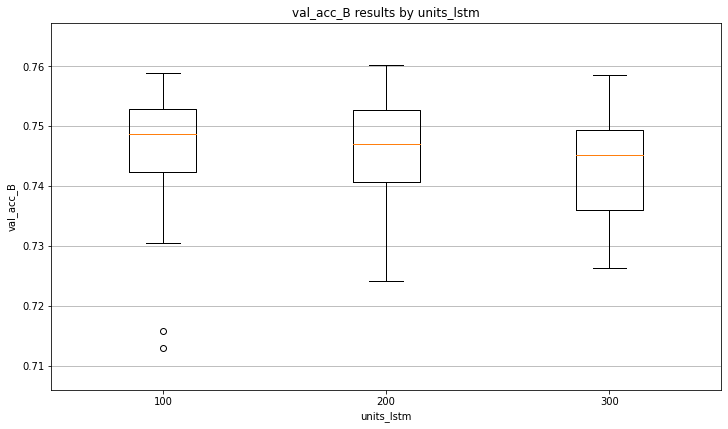

In [ ]:

params_dict = {'units_lstm':[100,200,300]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_B')

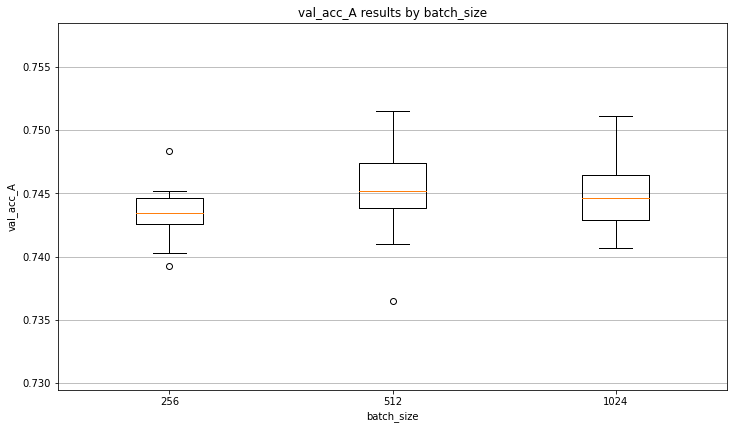

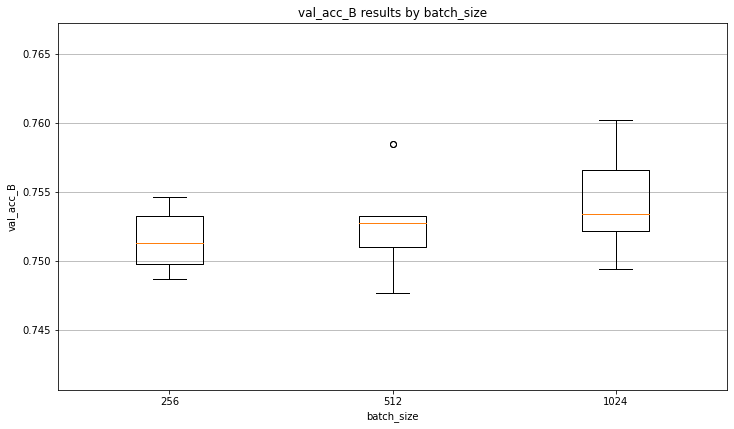

In [ ]:
optimizer_mask = results_df['optimizer'].isin(['adam-1e-3','adam-5e-4'])

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       {'batch_size':[256,512,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       {'batch_size':[256,512,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

### Resumen de los resultados

* lstm_units: [-100-,200]

* optimizador: [**'adam-1e-3'**, 'adam-5e-4']
* batch_size: [512,1024]

# Bloque 2 (dense_layers_sizes + lstm_units)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [13]:
from itertools import product

dense_layers_sizes = [(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)]  

arch_params = {'units_lstm':[100,150,200,250],
          'dense_layers_sizes':dense_layers_sizes,
          'merge_mode':['concat'],
          'lstm_dropout':[0.5],                      
          'dense_dropout':[0.5]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

6 arch_params_combos.


**Parámetros de la arquitectura**

In [14]:
trainig_params_dict = {'optimizer':['adam-5e-4'],
                       'batch_size':[512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [15]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


12 params combinations in the search_space.


## Escaneo

In [16]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          bidirectionalLSTM_NetModel, 
                          search_space[:],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/BiLSTM/HTA/experiments_2_2.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/BiLSTM/HTA/experiments_2_2.df
SCANNING SEARCH SPACE

12 configurations will be evaluated.
1  - conf_ID: sFTjRyyU   ****  --  train_acc_1 = 0.694,  val_acc_1 = 0.739    --  train_acc_2 = 0.742,  val_acc_2 = 0.747   
2  - conf_ID: UwWBaIdt   ****  --  train_acc_1 = 0.724,  val_acc_1 = 0.747    --  train_acc_2 = 0.714,  val_acc_2 = 0.754   
3  - conf_ID: rIZfwNcC   ****  --  train_acc_1 = 0.714,  val_acc_1 = 0.74     --  train_acc_2 = 0.744,  val_acc_2 = 0.755   
4  - conf_ID: aLjunByf   ****  --  train_acc_1 = 0.753,  val_acc_1 = 0.746    --  train_acc_2 = 0.711,  val_acc_2 = 0.756   
5  - conf_ID: RyVbNvqA   ****  --  train_acc_1 = 0.694,  val_acc_1 = 0.742    --  train_acc_2 = 0.729,  val_acc_2 = 0.753   
6  - conf_ID: QebhqscE   ****  --  train_acc_1 = 0.702,  val_acc_1 = 0.744    --  train_acc_2 = 0.732,  val_acc_2 = 0.755   
7  - conf_ID: DzvZjrUQ   ****  --  train_acc_1 = 0.693,  val_acc_1 = 0.743    --  train_acc_2 = 0.706,  val_acc_2 = 0.752   
8  - conf_ID:

## Resultados

In [22]:
import pickle
with open('./Results/BiLSTM/HTA/experiments_2.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head(5)

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

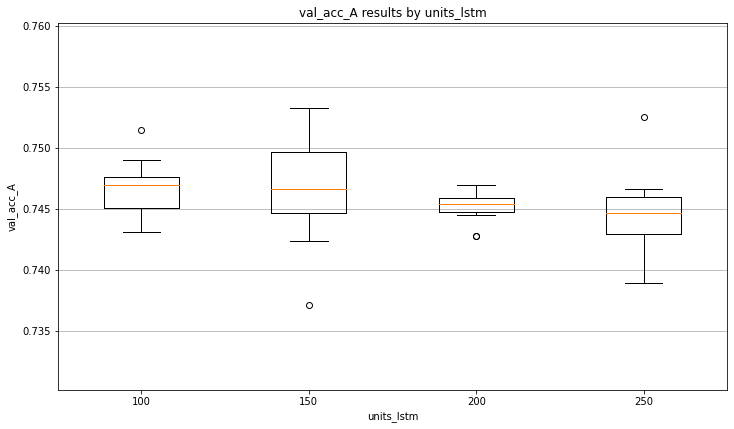

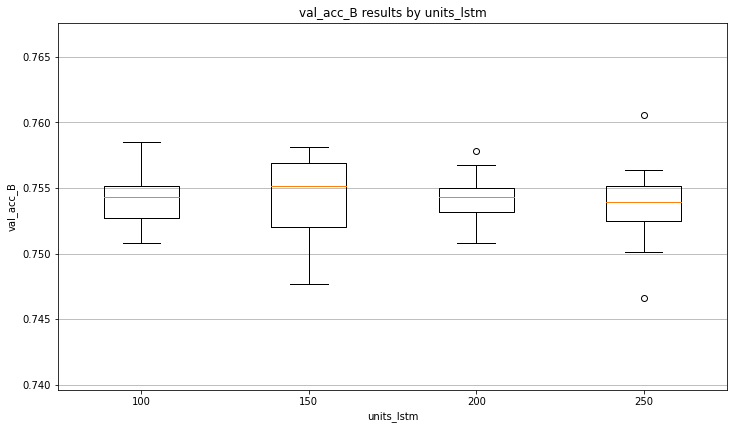

In [24]:
params_dict = {'units_lstm':[100,150,200,250]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_B')

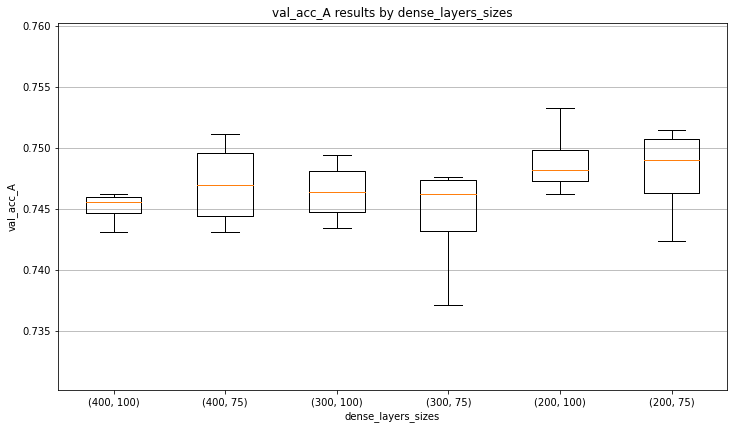

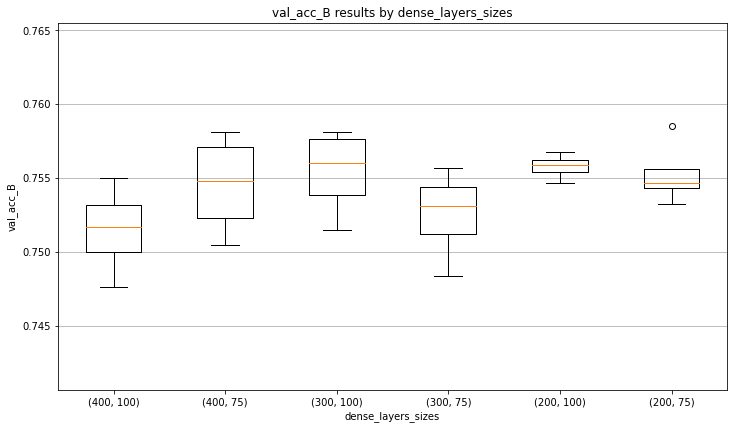

In [ ]:
params_dict = {'dense_layers_sizes':[(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)]}   

units_lstm_mask = results_df['units_lstm']<200
results_subset = results_df.loc[units_lstm_mask]  

results_utils.plotResultsByParameter1(results_df.loc[units_lstm_mask], 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df.loc[units_lstm_mask], 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_B')

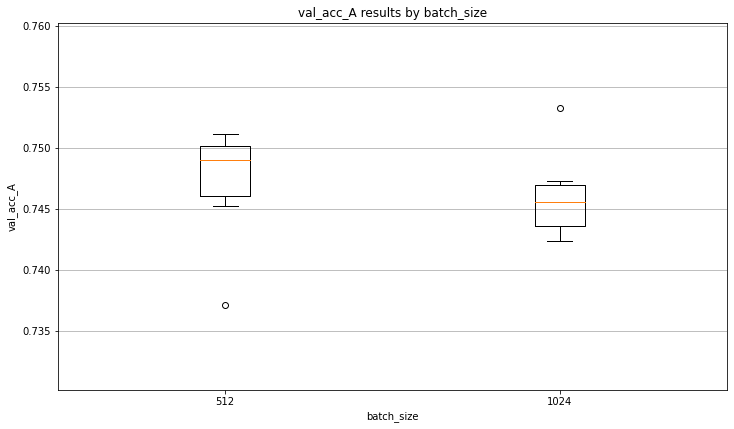

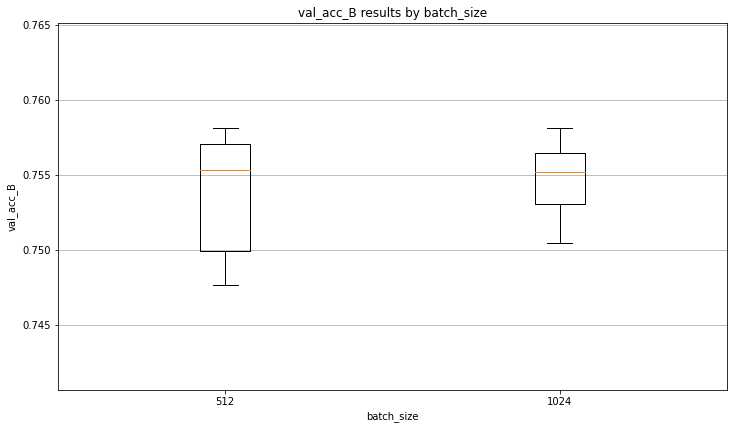

In [ ]:
params_dict = {'batch_size':[512,1024]}  

units_lstm_mask = results_df['units_lstm']==150

results_utils.plotResultsByParameter1(results_df.loc[units_lstm_mask], 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

units_lstm_mask = results_df['units_lstm']==150
results_utils.plotResultsByParameter1(results_df.loc[units_lstm_mask], 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

### Resumen de los resultados

* lstm_units: [100,**150**]
* dense_layers_sizes: [**(200,100),(300,100)**,(200,75)]


* optimizador: ['adam-1e-3', 'adam-5e-4']
* batch_size: [**512**, 1024]

# Bloque 3 (dropout)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[150],
          'dense_layers_sizes': dense_layers_sizes,
          'merge_mode':['concat'],
          'lstm_dropout':[0.3,0.5,0.7],                      
          'dense_dropout':[0.3,0.5,0.7]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

18 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-5e-4'],
                       'batch_size':[512,1024],
                       'max_epochs':[75]}
                        
training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


36 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HTA',
                          bidirectionalLSTM_NetModel, 
                          search_space[:15],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/LSTM/BiLSTM/HTA_experiments_3.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
with open('./Results/LSTM/BiLSTM/HTA_experiments_3.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(36, 16)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

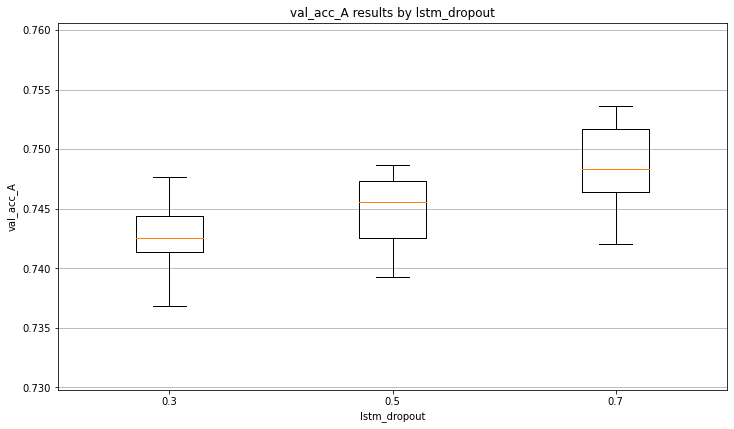

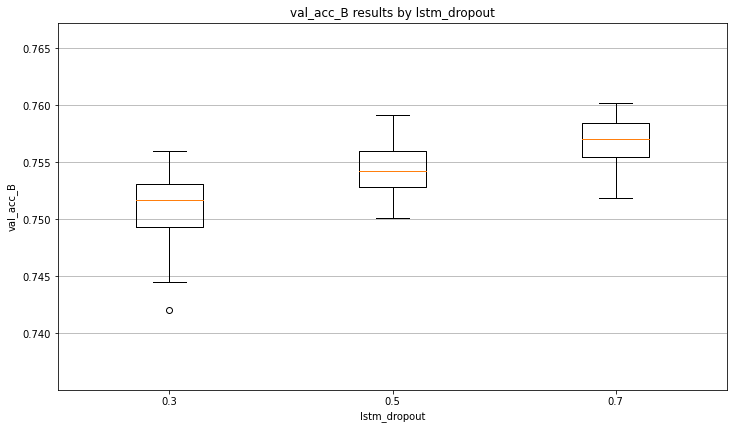

In [ ]:
params_dict = {'lstm_dropout':[0.3,0.5,0.7]}   

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['lstm_dropout'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['lstm_dropout'],
                       metric='val_acc_B')

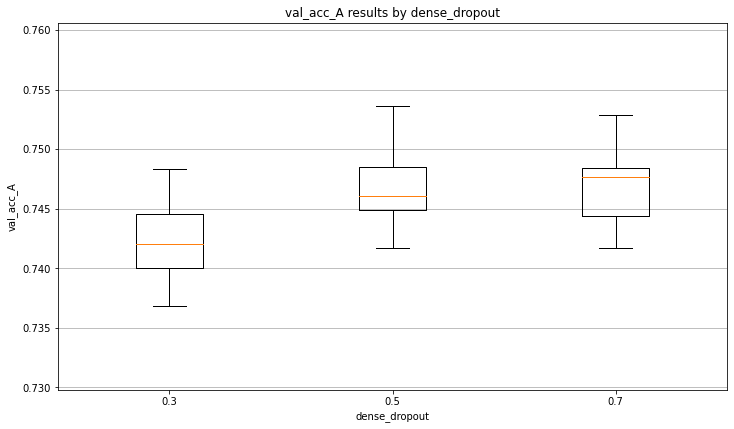

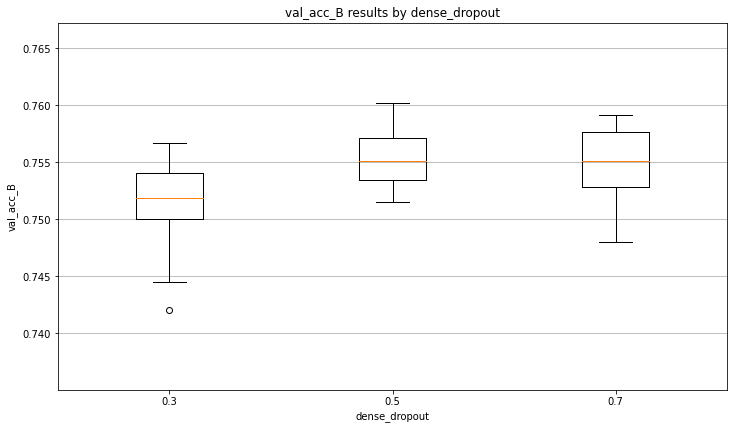

In [ ]:
params_dict = {'dense_dropout':[0.3,0.5,0.7]}   

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_B')

### Resumen de los resultados

* lstm_units: [100,150]
* dense_layers_sizes: [(200,100),(300,100)]
* lstm_dropout: 0.7
* dense_dropout: [0.5,0.7]


* optimizador: ['adam-1e-3', 'adam-5e-4']
* batch_size: [**512**, 1024]

# Bloque 4 (validación completa)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[100,150],
          'dense_layers_sizes': dense_layers_sizes,
          'merge_mode':['concat'],
          'lstm_dropout':[0.7],                      
          'dense_dropout':[0.5,0.7]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

12 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3','adam-5e-4'],
                       'batch_size':[512, 1024],
                       'max_epochs':[75]}
                        
training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


4 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = spaceScanner(X_train, Y_train,
                          'HTA',
                          bidirectionalLSTM_NetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=2,
                          stop_threshold=1,
                          partial_CV=False,
                          backup_file='./Results/LSTM/BiLSTM/HTA_experiments_4f.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=True,
                          save_weights=True)

## Resultados

In [25]:
import pickle
from pandas import DataFrame

with open('./Results/BiLSTM/HTA/experiments_4f.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(32, 17)

In [26]:
search_results.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,units_lstm,dense_layers_sizes,merge_mode,lstm_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
12,AaAfwcAd,100,"(200, 100)",concat,0.7,0.7,adam-1e-3,512,75,34,0.717500,0.764001,30,57,37,0.735467,0.773399
4,IkVKqPgr,100,"(300, 100)",concat,0.7,0.7,adam-1e-3,1024,75,49,0.722534,0.763603,28,67,48,0.715433,0.770001
28,WMgyUskY,150,"(200, 100)",concat,0.7,0.7,adam-1e-3,512,75,28,0.713567,0.760999,24,36,30,0.718567,0.769601
14,NqCxMCfs,100,"(200, 100)",concat,0.7,0.7,adam-5e-4,512,75,66,0.740467,0.760004,35,73,49,0.719001,0.771403
21,UXkEVLOO,150,"(300, 100)",concat,0.7,0.7,adam-1e-3,1024,75,46,0.725567,0.759401,38,60,52,0.733166,0.767802


In [27]:
search_results.sort_values(by='val_acc_B', ascending=False).head()

,conf_ID,units_lstm,dense_layers_sizes,merge_mode,lstm_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
12,AaAfwcAd,100,"(200, 100)",concat,0.7,0.7,adam-1e-3,512,75,34,0.717500,0.764001,30,57,37,0.735467,0.773399
14,NqCxMCfs,100,"(200, 100)",concat,0.7,0.7,adam-5e-4,512,75,66,0.740467,0.760004,35,73,49,0.719001,0.771403
4,IkVKqPgr,100,"(300, 100)",concat,0.7,0.7,adam-1e-3,1024,75,49,0.722534,0.763603,28,67,48,0.715433,0.770001
28,WMgyUskY,150,"(200, 100)",concat,0.7,0.7,adam-1e-3,512,75,28,0.713567,0.760999,24,36,30,0.718567,0.769601
29,CfKziEoZ,150,"(200, 100)",concat,0.7,0.7,adam-1e-3,1024,75,58,0.736100,0.758805,39,67,58,0.735000,0.769403
